### Data Processing & Feature Engineering

In [ ]:
import pandas as pd

ten_minute_df = pd.read_csv("jena_climate_2009_2016.csv")

In [ ]:
hourly_df = ten_minute_df[5::6]

In [ ]:
hourly_df.loc[:, 'timestamp'] = pd.to_datetime(hourly_df['Date Time'])
hourly_df.loc[:, 'year'] = hourly_df['timestamp'].dt.year
hourly_df.loc[:, 'month'] = hourly_df['timestamp'].dt.month
hourly_df.loc[:, 'day'] = hourly_df['timestamp'].dt.day
hourly_df.loc[:, 'hour'] = hourly_df['timestamp'].dt.hour


<ipython-input-3-a063bfd26031>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df.loc[:, 'timestamp'] = pd.to_datetime(hourly_df['Date Time'])
<ipython-input-3-a063bfd26031>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hourly_df.loc[:, 'year'] = hourly_df['timestamp'].dt.year
<ipython-input-3-a063bfd26031>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [ ]:
hourly_df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),timestamp,year,month,day,hour
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7,2009-01-01 01:00:00,2009,1,1,1
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3,2009-01-01 02:00:00,2009,1,1,2
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2,2009-01-01 03:00:00,2009,1,1,3
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0,2009-01-01 04:00:00,2009,1,1,4
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0,2009-01-01 05:00:00,2009,1,1,5


<Axes: xlabel='Date Time'>

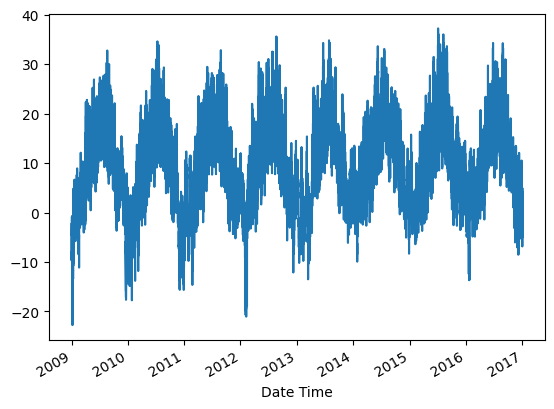

In [ ]:
temp = hourly_df['T (degC)']
temp.plot()

In [ ]:
hourly_df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)', 'timestamp', 'year', 'month', 'day', 'hour'],
      dtype='object')

In [ ]:
hourly_df = hourly_df[['Date Time', 'p (mbar)', 'T (degC)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'hour', 'day', 'year', 'month']]
hourly_df = hourly_df.rename(columns={'p (mbar)': 'p', 'T (degC)':'temp', 'Tdew (degC)': 'tdew',
       'rh (%)': 'rh', 'VPmax (mbar)': 'vpm'})

In [ ]:
hourly_df.head()

nan_count = hourly_df.isna().sum().sum()
print(nan_count)

0


In [ ]:
train_df = hourly_df[:60000]
valid_df = hourly_df[60000:65000]
test_df = hourly_df[65000:]

In [ ]:
def create_XY(df, multi=True):
    X = df[['temp', 'hour', 'tdew', 'vpm', 'day', 'month', 'year']]
    Y = df[['temp']]
    if multi:
      return X,Y
    return Y,Y

In [ ]:
X_train, Y_train = create_XY(train_df)
X_valid, Y_valid = create_XY(valid_df)
X_test, Y_test = create_XY(test_df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train = x_scaler.fit_transform(X_train)
Y_train = y_scaler.fit_transform(Y_train)

X_valid, Y_valid = x_scaler.transform(X_valid), y_scaler.transform(Y_valid)
X_test, Y_test = x_scaler.transform(X_test), y_scaler.transform(Y_test)

In [ ]:
import numpy as np
import torch

def build_feature_target_tensors(X, Y, input_window, pred_window):
    """
    Create input and output sequences for model training and return them as PyTorch tensors.

    :param X: 2D numpy array where rows are time steps and columns are features, including 'temp'.
    :param Y: 1D numpy array of target variable (temperature), extracted as Y = X[:, temp_index].
    :param input_window: Number of days to use as input sequences.
    :param pred_window: Number of days to predict.

    :return: X_tensor, Y_tensor - Tensors of input sequences and corresponding target sequences.
    """

    input_hours = input_window * 24
    prediction_hours = pred_window * 24

    assert X.shape[0] == Y.shape[0], "X and Y must have the same number of rows."

    X_sequences, Y_sequences = [], []

    for i in range(0, X.shape[0] - input_hours - prediction_hours + 1, 24):
        x_sequence = X[i:i+input_hours]
        y_sequence = Y[i+input_hours:i+input_hours+prediction_hours]

        X_sequences.append(x_sequence)
        Y_sequences.append(y_sequence)

    # Convert the lists of sequences to numpy arrays and then to PyTorch tensors
    X_tensor = torch.tensor(np.array(X_sequences), dtype=torch.float)
    Y_tensor = torch.tensor(np.array(Y_sequences), dtype=torch.float)

    return X_tensor, Y_tensor


In [ ]:
# given input_window days of feature data, make a prediction for temp (hourly) for the next pred_window days
input_window = 7 #(7 * 24)
pred_window = 1 #(24)

In [ ]:
X_train_tensor, Y_train_tensor = build_feature_target_tensors(X_train, Y_train, input_window, pred_window)
X_valid_tensor, Y_valid_tensor = build_feature_target_tensors(X_valid, Y_valid, input_window, pred_window)
X_test_tensor, Y_test_tensor = build_feature_target_tensors(X_test, Y_test, input_window, pred_window)

### Model Architecture & Training

In [ ]:
import torch
import torch.nn as nn
import math

class Transformer(nn.Module):
    def __init__(self, num_features, d_model, nhead, num_layers, dim_feedforward, dropout=0.1, output_seq_len=168):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.output_seq_len = output_seq_len
        self.embedding = nn.Linear(num_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.output_layer = nn.Linear(d_model, output_seq_len)

    def forward(self, src):
        # src shape: (batch_size, seq_len, num_features)

        # Embedding + positional encoding
        src = self.embedding(src) * math.sqrt(self.d_model)

        # Pass through the transformer encoder
        encoded_output = self.transformer_encoder(src)

        # We take the last timestep output and pass it through the output linear layer
        # The output linear layer will output one value per future timestep, total of output_seq_len values
        output = self.output_layer(encoded_output[:, -1, :])

        # The output shape is (batch_size, output_seq_len), where output_seq_len is 168 for a week
        return output

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
num_features = 7
d_model = 96
nhead = 6
num_layers = 4
dim_feedforward = 512
dropout = 0.2
output_seq_len = pred_window * 24 #1 day worth of predictions

In [ ]:
import torch
import torch.nn as nn

class TrendValueLoss(nn.Module):
    def __init__(self, trend_weight=0.5, value_weight=0.5):
        super(TrendValueLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.trend_weight = trend_weight
        self.value_weight = value_weight

    def forward(self, y_pred, y_true):
        value_loss = self.mse_loss(y_pred, y_true)
        true_gradient = torch.diff(y_true, dim=1)
        pred_gradient = torch.diff(y_pred, dim=1)
        trend_loss = self.mse_loss(pred_gradient, true_gradient)

        custom_loss = (self.trend_weight * trend_loss) + (self.value_weight * value_loss)

        return custom_loss


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

model = Transformer(num_features, d_model, nhead, num_layers, dim_feedforward, dropout, output_seq_len)
model.to(device)

criterion = TrendValueLoss(trend_weight = 0.4, value_weight=1)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

num_epochs = 100

batch_size = 24
X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = (Y_train_tensor.to(device)).squeeze(-1)
X_valid_tensor = X_valid_tensor.to(device)
Y_valid_tensor = (Y_valid_tensor.to(device)).squeeze(-1)

model.train()  # Set the model to training mode

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i + batch_size]
        Y_batch = Y_train_tensor[i:i + batch_size]

        optimizer.zero_grad()

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(X_train_tensor)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        Y_val_pred = model(X_valid_tensor)
        val_loss = criterion(Y_val_pred, Y_valid_tensor)
        valid_losses.append(val_loss.item())

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss.item():.4f}')


Epoch 1/100, Training Loss: 0.1473, Validation Loss: 0.0188
Epoch 2/100, Training Loss: 0.0568, Validation Loss: 0.0170
Epoch 3/100, Training Loss: 0.0454, Validation Loss: 0.0133
Epoch 4/100, Training Loss: 0.0348, Validation Loss: 0.0108
Epoch 5/100, Training Loss: 0.0276, Validation Loss: 0.0087
Epoch 6/100, Training Loss: 0.0221, Validation Loss: 0.0095
Epoch 7/100, Training Loss: 0.0193, Validation Loss: 0.0076
Epoch 8/100, Training Loss: 0.0171, Validation Loss: 0.0072
Epoch 9/100, Training Loss: 0.0159, Validation Loss: 0.0085
Epoch 10/100, Training Loss: 0.0145, Validation Loss: 0.0095
Epoch 11/100, Training Loss: 0.0137, Validation Loss: 0.0076
Epoch 12/100, Training Loss: 0.0125, Validation Loss: 0.0071
Epoch 13/100, Training Loss: 0.0120, Validation Loss: 0.0073
Epoch 14/100, Training Loss: 0.0110, Validation Loss: 0.0077
Epoch 15/100, Training Loss: 0.0103, Validation Loss: 0.0066
Epoch 16/100, Training Loss: 0.0095, Validation Loss: 0.0064
Epoch 17/100, Training Loss: 0.00

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses, valid_losses, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training Loss')
    plt.plot(valid_losses, label=f'Validation Loss')
    plt.title(f'Loss Curves: {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

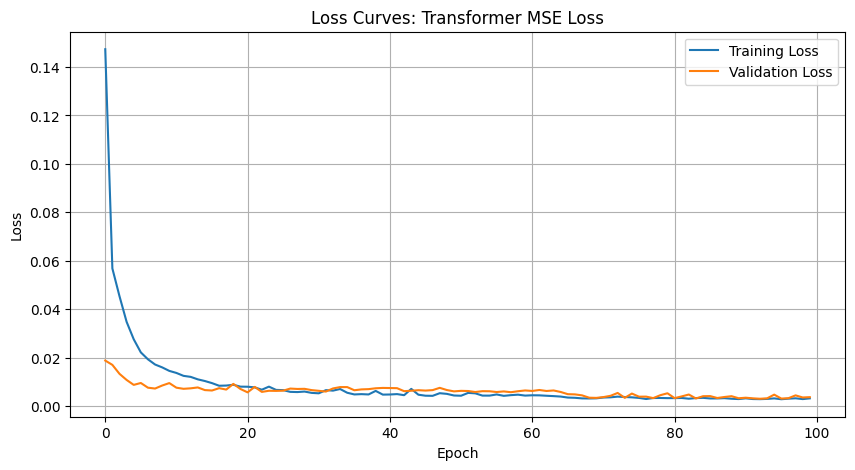

In [ ]:
plot_loss_curves(train_losses, valid_losses, "Transformer MSE Loss")

### Model Evaluation and Visualization

In [ ]:
torch.save(model.state_dict(), "multi_transformer_state_dict.pth")

In [ ]:
tformer = Transformer(num_features, d_model, nhead, num_layers, dim_feedforward, dropout, output_seq_len)
tformer.load_state_dict(torch.load("multi_transformer_state_dict.pth"))
tformer.eval()

Transformer(
  (embedding): Linear(in_features=7, out_features=96, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
        (linear1): Linear(in_features=96, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=96, bias=True)
        (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=96, out_features=24, bias=True)
)

In [ ]:
model = tformer

In [ ]:
import torch.nn as nn
import torch

# X_test_tensor, Y_test_tensor = X_test_tensor.to(device), Y_test_tensor.to(device)
Y_test_tensor = Y_test_tensor.squeeze(-1)
criterion = nn.MSELoss()
with torch.no_grad():
  Y_pred = model(X_test_tensor)
  test_loss = criterion(Y_pred, Y_test_tensor)

print(f"Test MSE Loss: {test_loss.item()}")

Test MSE Loss: 0.006807372905313969


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, X_test, Y_test, y_scaler):
    model.eval()

    all_predictions = []
    all_actuals = []
    first_input_sequence = []

    with torch.no_grad():
        for i in range(len(X_test)):
            # Get prediction for the ith test sequence
            single_prediction = model(X_test[i].unsqueeze(0)).squeeze(0)

            # Store predictions, actual values, and the first input sequence
            all_predictions.append(single_prediction)
            all_actuals.append(Y_test[i])

            if i == 0:  # Store the first input sequence to plot it
                first_input_sequence = X_test[i, :, 0]  # Assuming temp is the first feature

    # Convert to numpy arrays for processing
    all_predictions_np = np.concatenate(all_predictions, axis=0)
    all_actuals_np = np.concatenate(all_actuals, axis=0)
    first_input_sequence_np = first_input_sequence.cpu().numpy()

    # Rescale the predictions, actuals, and the first input sequence
    all_predictions_rescaled = y_scaler.inverse_transform(all_predictions_np.reshape(-1, 1)).flatten()
    all_actuals_rescaled = y_scaler.inverse_transform(all_actuals_np.reshape(-1, 1)).flatten()
    first_input_sequence_rescaled = y_scaler.inverse_transform(first_input_sequence_np.reshape(-1, 1)).flatten()

    # Time axis for plotting
    input_time = np.arange(-len(first_input_sequence_rescaled), 0, 1)
    forecast_time = np.arange(0, len(all_predictions_rescaled), 1)

    plt.figure(figsize=(12, 6))

    # Plotting the input sequence
    plt.plot(input_time, first_input_sequence_rescaled, label='Input Temp (First Sequence)', color='forestgreen')

    # Plotting the actuals and predictions
    plt.plot(forecast_time, all_actuals_rescaled, label='Actuals', linestyle='--', color='darkorange')
    plt.plot(forecast_time, all_predictions_rescaled, label='Predictions', color='royalblue')

    # Add a vertical line to indicate the start of the forecast
    plt.axvline(x=0, color='gray', linestyle='--', label='Forecast Start')

    plt.title('Test Set Predictions vs. Actuals (Rescaled)')
    plt.xlabel('Time (Hours)')
    plt.ylabel('Temperature')
    plt.legend()
    plt.show()

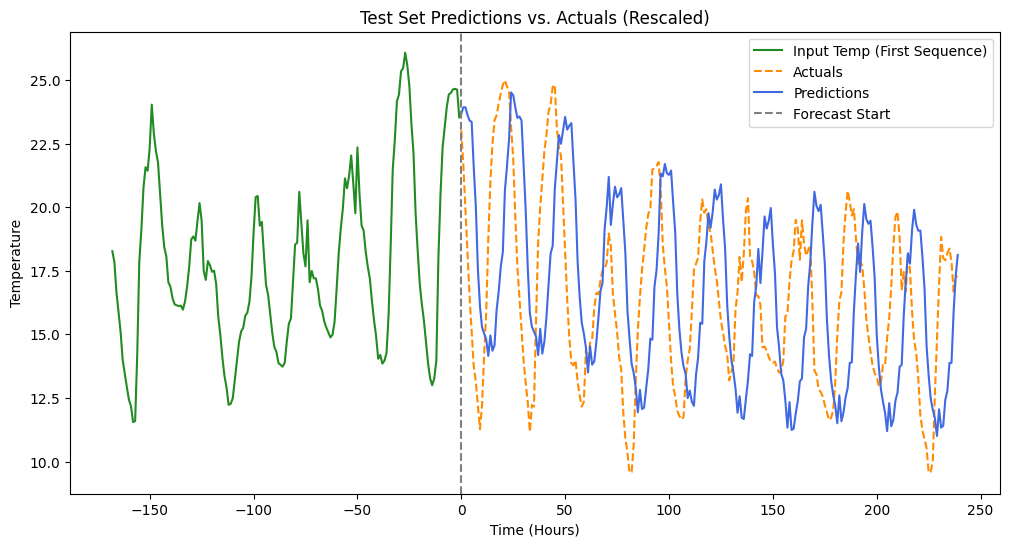

In [ ]:
plot_predictions(model, X_test_tensor[:10], Y_test_tensor[:10], y_scaler)

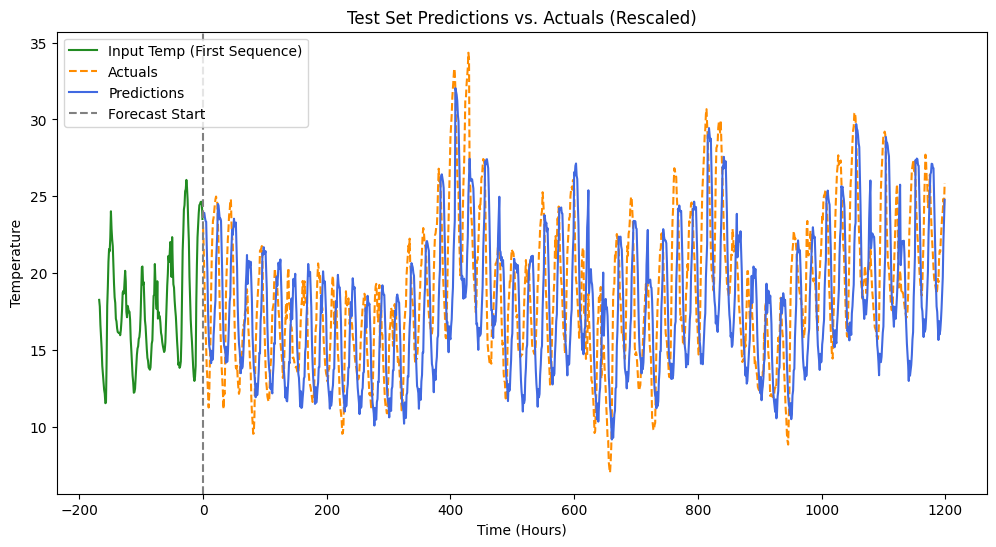

In [ ]:
plot_predictions(model, X_test_tensor[:50], Y_test_tensor[:50], y_scaler)